In [0]:
from pyspark.sql import SparkSession
from pyspark.dbutils import DBUtils
import os
from pyspark.sql.functions import col
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.functions import  pandas_udf, PandasUDFType
from typing import Iterator, Tuple
from pyspark.sql.types import BinaryType
from PIL import Image   
import numpy as np
import io
from pyspark.sql.functions import udf,col
from pyspark.sql.types import StringType
import cv2
from pyspark import SparkFiles
import matplotlib.pyplot as plt
sas_token = os.environ.get("AZURE_STORAGE_SAS")
spark = SparkSession.builder.getOrCreate()
dbutils = DBUtils(spark)


In [0]:
storageAccountName = 'condiscvstorageblobdev'
containerName = 'ds-computervision'
sas_token = os.getenv("AZURE_STORAGE_SAS")
sas = f"{sas_token}"
config = "fs.azure.sas." + containerName+ "." + storageAccountName + ".blob.core.windows.net"


In [0]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")
date = '20211027'
path = (f'/mnt/dscomputervision/async/wc=000/dt={date}/')
df = spark.read.format('binaryFile').option("pathGlobFilter", "*.np").option("recursiveFileLookup", "true").load(path).limit(50)
df.cache().count()

Out[110]: 50

In [0]:
YOLOV3_LABELS_PATH = "dbfs/mnt/dscomputervision/model/yolo-coco-data/coco.names"
YOLOV3_CFG_PATH = "/dbfs/mnt/dscomputervision/model/yolo-coco-data/yolov3.cfg"
YOLOV3_WEIGHTS_PATH = "/dbfs/mnt/dscomputervision/model/yolo-coco-data/yolov3.weights"

In [0]:
# Load YOLO Model
def load_model(CFG_PATH, WEIGHTS_PATH):
    """[summary]

    Args:
        CFG_PATH (Union[Path, str]): [description]
        WEIGHTS_PATH (Union[Path, str]): [description]

    Returns:
        cv2.dnn_Net: [description]
    """
    return cv2.dnn.readNetFromDarknet(CFG_PATH, WEIGHTS_PATH)
  


In [0]:
# Load Layer_names
def get_layer_names(model):
    """[summary]

    Args:
        model (cv2.dnn_Net): [description]

    Returns:
        list: [description]
    """
    layer_names = model.getLayerNames()
    return [layer_names[i[0] - 1] for i in model.getUnconnectedOutLayers()]



In [0]:
def layer_outputs(img, layer_names, model):
    """Creation of 4-dim blob from initial image, crops images from the center 
    and resizes

    Args:
        img (numpy.ndarray): Current frame represented as an array of ints, with each array position holding ints for rgb channels
        layer_names (String): Path to YOLO Layer Names file
        model (cv2.dnn_Net): Loaded YOLO model

    Returns:
        [List(numpy.ndarray)]: Returns all layer outputs of image
    """
    blob = cv2.dnn.blobFromImage(img, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    model.setInput(blob)
    return model.forward(layer_names)

In [0]:
def nms_scores(
    outputs, IMG_HEIGHT, IMG_WIDTH):
    """Detecting people in frame and drawing boxes around them. Scores identify
    anything found in video frame. The classID and confidence ensures that the 
    model is 50% sure the object is a person (classID = 0 is a person). It then
    records the remaining dectection information (Height and Width of Boxes, 
    Class ID, and Confidence) in boxes which is appended to results.

    Args:
        outputs (List(numpy.ndarray)): All layer_outputs from YOLO model detection
        IMG_HEIGHT (int): Image Height
        IMG_WIDTH (int): Image Width

    Returns:
        [np.array]: Array of all boxes and their corresponding info
    """
    results = np.empty((0, 6), dtype="float")
    for row in outputs:
        scores = row[:, 5:]
        classIDs = scores.argmax(axis=1)
        confidence = scores.max(axis=1)

        # Confidence score greater than .5 and Class is a person
        indices = np.where((classIDs == 0) & (confidence > 0.5))
        boxes = row[indices, 0:4][0] * np.array(
            [IMG_WIDTH, IMG_HEIGHT, IMG_WIDTH, IMG_HEIGHT]
        )

        boxes = boxes.astype("int").astype("float")
        boxes = np.insert(boxes, 0, confidence[indices], axis=1)
        boxes = np.insert(boxes, 0, classIDs[indices], axis=1)
        results = np.append(results, boxes, axis=0)

    res = cv2.dnn.NMSBoxes(
        results[:, 2:].astype("int").tolist(), results[:, 1].tolist(), 0.5, 0.3
    )
    if len(res) == 0:
        return np.array([])
    return results[res.flatten(), :]

In [0]:
def draw_rectangle(img, nms_scores):
    """Draws rectangles on detected object class on the original image input

    Args:
        img (np.ndarray): image frame
        nms_scores (Union[list, np.ndarray]): a list of detected class object and its coordinates and confidence

    Returns:
        np.ndarray: image with rectangles surrounding detected object(s)
    """
    for nms in nms_scores:
        (center_x, center_y) = (nms[2], nms[3])
        (w, h) = (nms[4], nms[5])
        x = int(center_x - w / 2)
        y = int(center_y - h / 2)
        cv2.rectangle(
            img, (int(x), int(y)), (int(x) + int(w), int(y) + int(h)), (0, 0, 255), 3
        )

    return img


In [0]:
def preprocess(image_bytes, file_name, model, layer_names):
    img = np.load(io.BytesIO(image_bytes)).flatten()
    img = img.reshape(480,640,3)
    #model = load_model(YOLOV3_CFG_PATH,YOLOV3_WEIGHTS_PATH)
    #layer_names = get_layer_names(model)
    layer_output = layer_outputs(img, layer_names, model)
    height, width = img.shape[:2]
    nms = nms_scores(layer_output, height, width)
    img = draw_rectangle(img, nms)
    img = img.flatten()

    return pd.Series(img)

In [0]:
@pandas_udf('array<int>')
def decompress_udf(content_series_iter: Iterator[Tuple[pd.Series, pd.Series]]) -> Iterator[pd.Series]:
  model = load_model(YOLOV3_CFG_PATH,YOLOV3_WEIGHTS_PATH)
  layer_names = get_layer_names(model)
  for content_series, filename_series in content_series_iter:
    zipped = zip(content_series, filename_series)
    yield pd.Series(map(lambda x: preprocess(x[0], x[1], model, layer_names), zipped))
    

In [0]:
new_df = df.withColumn("preprocessed",decompress_udf("content", "path"))

In [0]:
new_df.cache().count()

In [0]:
new_df.show()

+--------------------+-------------------+------+--------------------+--------------------+
 path| modificationTime|length| content| preprocessed|
+--------------------+-------------------+------+--------------------+--------------------+
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[205, 210, 183, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:55|921728|[93 4E 55 4D 50 5...|[202, 211, 178, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:55|921728|[93 4E 55 4D 50 5...|[202, 211, 178, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[201, 212, 179, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[207, 210, 184, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[207, 210, 184, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[203, 212, 175, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[203, 208, 177, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[206, 208, 178, 2...|
dbfs:/mnt/dscompu...|2021-10-27 16:54:56|921728|[93 4E 55 4D 50 5...|[206, 208, 178, 2...|
+--------------------+-------------------+------+--------------------+--------------------+

In [0]:
one_frame = new_df.select('preprocessed').take(10)[4]

In [0]:
frame = np.array(one_frame).reshape(480,640,3)

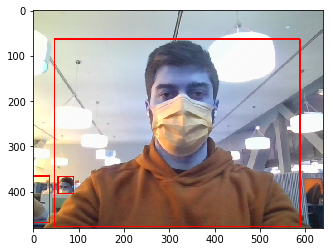

In [0]:
plt.imshow(frame)